# Notebook to transform signal-to-concentration values of field btc

### Import standard and personal modules

In [1]:
# Import modules
# %matplotlib inline
%matplotlib notebook
#%matplotlib nbagg
import numpy as np
import os
import sys
import matplotlib.pylab as plt
import pandas as pd
import pdb
import collections
from scipy.optimize import curve_fit, fmin
import datetime
import time
from scipy import interpolate
sys.path.append(os.path.abspath(os.path.join(os.curdir, '..', 'pycleaner')))
import functions.fielddata as fd
import functions.fitfun as pff
import functions.miscel
from matplotlib.ticker import FormatStrFormatter
from ipywidgets import widgets, Text, interactive, interact
from IPython.display import display
import aux_functions as af
import mywidgets as mw

### Tracer data from laboratory

###### Load the sampling configuration

In [1520]:
SourceDir_Ismatec = mw.createwidget('DirIsmatec', widgettype='text', bc='#BEB', defaultvalue=r'...Raw\ismatec\12122012')
SourceDir_hermes = mw.createwidget('DirHermes', widgettype='text', bc='#AAE', defaultvalue=r'...Raw\hermes\12122012_single')
Injection = mw.createwidget('InjectTime', widgettype='text', bc='#AAE', defaultvalue=r'12:12:12')
SourceDir_hermes.on_submit(af.def_dir)
SourceDir_Ismatec.on_submit(af.def_dir)
Injection.on_submit(af.def_dir)
#InjectionTime = '11:59:31'
# C:\Users\IRTG\Dropbox\LauswiesenDatabase\ipynb_1_RawData\tracertest\ismatec\17072015
# C:\Users\IRTG\Dropbox\LauswiesenDatabase\ipynb_1_RawData\tracertest\hermes\17072015\17072015_single
# 10:10:28

Directory (or file) < C:\Users\IRTG\Dropbox\LauswiesenDatabase\_Processed_Data\tracertest\hermes\17072015\17072015_single > is valid
Directory (or file) < 14:18:01 > is NOT valid!!!
Directory (or file) < C:\Users\IRTG\Dropbox\LauswiesenDatabase\_Processed_Data\tracertest\ismatec\17072015 > is valid


In [1500]:
SourceDir_Ismatec

In [1521]:
btcPath = SourceDir_hermes.value
InjectionTime = Injection.value
mydate = os.path.split(SourceDir_Ismatec.value)[-1]
SourceDir_Ismatec = os.path.split(SourceDir_Ismatec.value)[0]
sampleList = os.listdir(os.path.join(SourceDir_Ismatec, mydate))
sampleList = [x for x in sampleList if 'calib' not in x and 'config' not in x]
samp_config = pd.read_table(os.path.join(SourceDir_Ismatec, mydate, '%s_config.txt' %mydate), usecols=(0,2), skiprows=9, header=0 )

__1.- Calibration Curve__

Note:Interpolation of the calibration curve happens in arithmetic and log scale

<IPython.core.display.Javascript object>


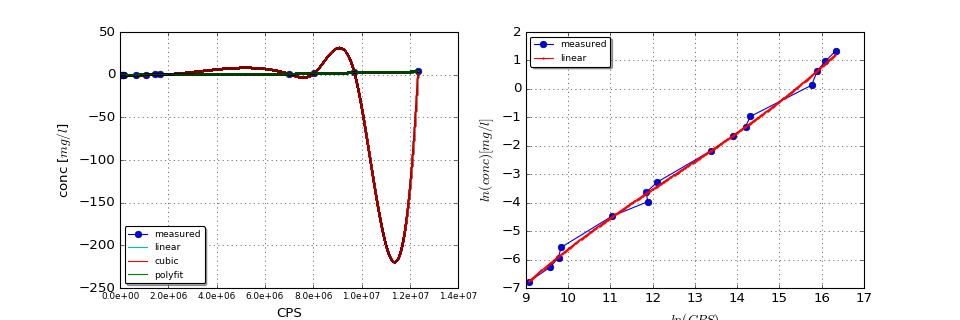

In [1531]:
calib_curve = pd.read_table(os.path.join(SourceDir_Ismatec, mydate, '%s_calibcurve.txt' %mydate), usecols=(0,1), skiprows=2, header=None,names=['conc','cps'] )
xnew = np.arange(calib_curve['cps'].min(), calib_curve['cps'].max(), 100)
finterp_1 = interpolate.interp1d(calib_curve['cps'], calib_curve['conc'], kind = 'linear')
finterp_2 = interpolate.interp1d(calib_curve['cps'], calib_curve['conc'], kind = 'cubic')
ffit_1 = np.poly1d(np.polyfit(calib_curve['cps'], calib_curve['conc'], 5))
ynew_interp_1 = finterp_1(xnew)
ynew_interp_2 = finterp_2(xnew)
ynew_fit_1 = ffit_1(xnew)
# Interpolate using log transformation:
# Perform interpolation (drop the last point of the calibration curve because is = 0)
calib_curve_log = calib_curve.drop([len(calib_curve)-1])
finterp_log = np.poly1d(np.polyfit(np.log(calib_curve_log['cps']), np.log(calib_curve_log['conc']), 3))
# New refined array:
xnew_log = np.arange(np.log(calib_curve_log['cps'].min()), np.log(calib_curve_log['cps'].max()), 0.025)
ynew_fit_log = finterp_log(xnew_log)
# Plot interpolated calibration curve:
fig3, ax3 = plt.subplots(1,2, figsize=(12, 4))
ax3[0].plot(calib_curve.cps, calib_curve.conc, 'b-o', label='measured')
ax3[0].plot(xnew, ynew_interp_1, 'c-o', ms=1, mew= 0.01,label='linear')
ax3[0].plot(xnew, ynew_interp_2, 'r-o', ms=1, mew= 0.01, label='cubic')
ax3[0].plot(xnew, ynew_fit_1, 'g-o', ms=1, mew= 0.01, label='polyfit')
ax3[0].legend(numpoints=1, fancybox=True, fontsize='x-small', shadow=True, loc='best')
ax3[0].grid(True)
ax3[0].set_xlabel('CPS')
ax3[0].set_ylabel('conc [$mg/l$]')
ax3[0].xaxis.set_major_formatter(FormatStrFormatter('%2.1e'))
ax3[0].tick_params(axis='x', labelsize=8)

ax3[1].plot(np.log(calib_curve.cps), np.log(calib_curve.conc), 'b-o', label='measured')
ax3[1].plot(xnew_log, ynew_fit_log, 'r-o', ms=2, mew= 0.01,label='linear')
ax3[1].grid(True)
ax3[1].legend(numpoints=1, fancybox=True, fontsize='x-small', shadow=True, loc='best')
ax3[1].set_xlabel('$ln (CPS)$')
ax3[1].set_ylabel('$ln (conc) [mg/l]$')

In [1532]:
# Load and transform field samples into concentrations:
well = 'B6'
cur_sample_cps = pd.read_table(os.path.join(SourceDir_Ismatec, mydate, '%s.txt' %well), usecols=(0,1), skiprows=5, header=None, names=['time', 'cps'] )
blank_cps = pd.read_table(os.path.join(SourceDir_Ismatec, mydate, '%s.txt' %well), usecols=(1,), skiprows=3, header=None, names=['cps'], nrows=1)
blank_array = pd.DataFrame(data=np.ones((len(cur_sample_cps.cps) ))* blank_cps.cps[0])
cur_sample_cps_woblank = (cur_sample_cps.cps -blank_array.T).T
cur_sample_cps_woblank_norm = cur_sample_cps_woblank.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))

<IPython.core.display.Javascript object>


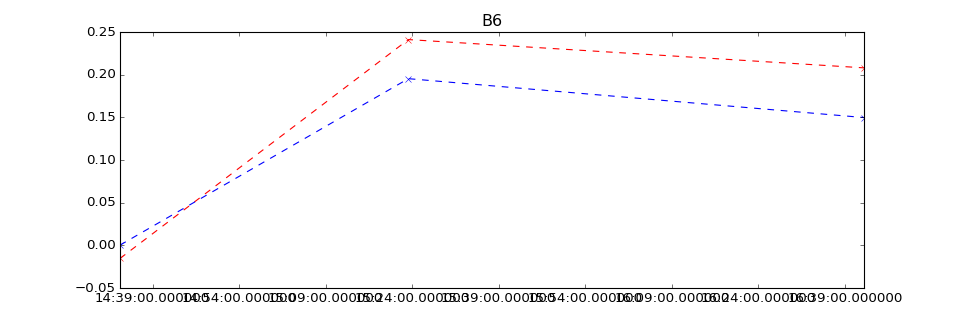

In [1533]:
plt.figure(2, figsize=(12,4))
plt.title(well)
plt.plot(pd.to_datetime(cur_sample_cps.time), ffit_1(cur_sample_cps_woblank), 'rx--')
# plt.plot(pd.to_datetime(cur_sample_cps.time), finterp_1(cur_sample_cps_woblank), 'cx--')
plt.plot(pd.to_datetime(cur_sample_cps.time), np.exp(finterp_log(np.log(cur_sample_cps_woblank))), 'bx--')


In [1534]:
# Load corresponding Breakthrough curves:
btcFile = '%s_modif.txt' %well
btc = pd.read_table(os.path.join(btcPath, btcFile), header=None, names=['time','signal'], sep=' ')
samp_times_sec = (pd.to_datetime(cur_sample_cps.time) - pd.to_datetime(InjectionTime)).dt.seconds
fieldsamples_conc = np.exp(finterp_log(np.log(cur_sample_cps_woblank)))
# fieldsamples_conc, samp_times_sec

<IPython.core.display.Javascript object>


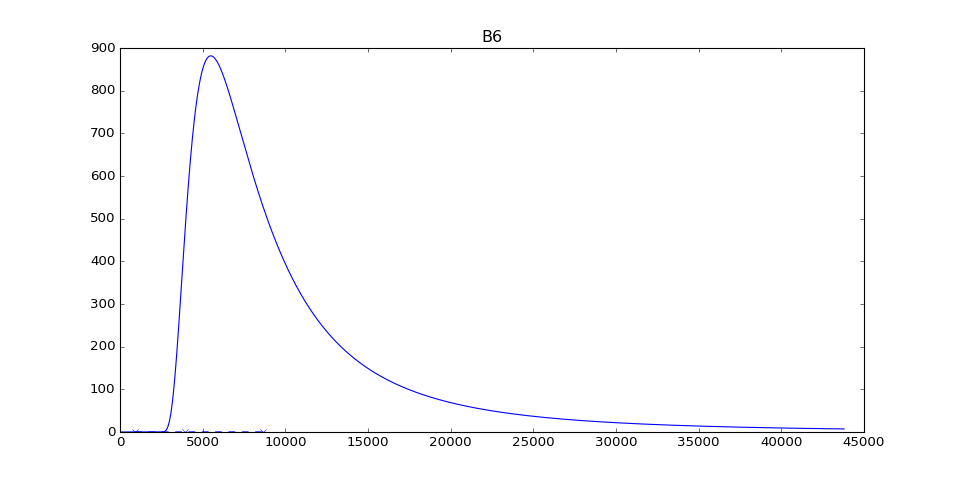

In [1535]:
plt.figure(3, figsize=(12,6))
pd.to_datetime(cur_sample_cps.time)
plt.title(well)
plt.plot(btc.time, btc.signal)
plt.plot(samp_times_sec, fieldsamples_conc, 'bx--')

In [1536]:
def timedelay(t):
    t = int(t)
    yfit1 = fd.interp_y(btc.signal.values, samp_times_sec.values+t, fieldsamples_conc, well, mytype = 'norm' )
    #%% (opt 1) Attemp to make an fmin search minimizing the distance between points
    yfit2 = fd.interp_y(btc.signal.values, samp_times_sec.values+t, fieldsamples_conc, well, mytype = 'fmin' )
    #%% (opt 2) Perform a standard linear regression to get actual concentratons for all btc
    # yfit3 = fd.interp_y(btc.signal.values, samp_times_sec.values, fieldsamples_conc, well, mytype = 'lin' )
    #%% (opt 2) Perform a standard linear regression to get actual concentratons for all btc
    yfit4 = fd.interp_y(btc.signal.values, samp_times_sec.values+t, fieldsamples_conc, well, mytype = 'ls_nointerc' )
    plt.figure(4, figsize=(12,6))
    plt.plot(samp_times_sec+t,fieldsamples_conc,'bo')
    plt.plot(btc.time,yfit1, 'r--', label = 'fit by factor=max(conc)')
    plt.plot(btc.time,yfit2, 'b--', label = 'fimin search fit')
    # plt.plot(btc.time, yfit3, 'k--',label = 'regression fit')
    plt.plot(btc.time, yfit4, 'c--',label = 'ls no interc')
    plt.legend(loc = 'best')
    plt.title(well)
    plt.grid(True)
    return yfit1, yfit2, yfit4

Optimization terminated successfully.
         Current function value: 0.065348
         Iterations: 15
         Function evaluations: 30


<IPython.core.display.Javascript object>


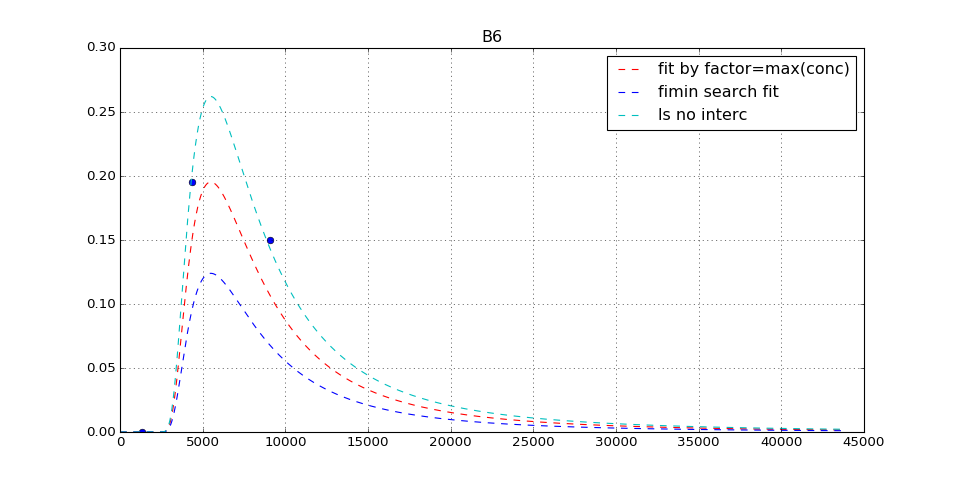

(array([ 0.        ,  0.        ,  0.        , ...,  0.00158592,
         0.00158581,  0.0015857 ]),
 array([ 0.        ,  0.        ,  0.        , ...,  0.00100669,
         0.00100662,  0.00100655]),
 array([ 0.        ,  0.        ,  0.        , ...,  0.00212825,
         0.00212811,  0.00212796]))

In [1537]:
tt = interact(timedelay,t=2000)
# tt = interact(timedelay,t='0')

In [1529]:
yfit1, yfit2, yfit4 = tt.widget.result

checkboxes = []
cb_container = widgets.HBox(align_items='stretch', border='3px solid black', display='flex' )
display(cb_container)
fit1_max = checkboxes.append(widgets.Checkbox(description='MaxValue', value=False, width=80))
fit2_fmin = checkboxes.append(widgets.Checkbox(description='fminsearch', value=False,width=80))
fit4_ls_noint = checkboxes.append(widgets.Checkbox(description='lsNointercept', value=True,width=80))
cb_container.children = [i for i in checkboxes]

In [1530]:
if cb_container.children[0].value == True:
    yfit = yfit1
if cb_container.children[1].value == True:
    yfit = yfit2
if cb_container.children[2].value == True:
    yfit = yfit4

np.savetxt(os.path.join(btcPath, '%s_modif_conc.txt' %well), np.transpose((btc.time,yfit)))

In [ ]:
# (opt 0) Normalize and scale by the max of lab measurements:
time_delay = 10000
yfit1 = fd.interp_y(btc.signal.values, samp_times_sec.values+time_delay, fieldsamples_conc, well, mytype = 'norm' )
#%% (opt 1) Attemp to make an fmin search minimizing the distance between points
yfit2 = fd.interp_y(btc.signal.values, samp_times_sec.values+time_delay, fieldsamples_conc, well, mytype = 'fmin' )
#%% (opt 2) Perform a standard linear regression to get actual concentratons for all btc
# yfit3 = fd.interp_y(btc.signal.values, samp_times_sec.values, fieldsamples_conc, well, mytype = 'lin' )
#%% (opt 2) Perform a standard linear regression to get actual concentratons for all btc
yfit4 = fd.interp_y(btc.signal.values, samp_times_sec.values+time_delay, fieldsamples_conc, well, mytype = 'ls_nointerc' )
plt.plot(samp_times_sec+time_delay,fieldsamples_conc,'bo')
plt.plot(btc.time,yfit1, 'r--', label = 'fit by factor=max(conc)')
plt.plot(btc.time,yfit2, 'b--', label = 'fimin search fit')
# plt.plot(btc.time, yfit3, 'k--',label = 'regression fit')
plt.plot(btc.time, yfit4, 'c--',label = 'ls no interc')
plt.legend(loc = 'best')
plt.grid(True)

In [ ]:
yfit1,yfit2,yfit4

In [ ]:
blancs = pd.read_excel(sample_setup_xls, sheetname='Lab%s' % mydate, parse_cols="AH,AI",header=None)
blancs = blancs.dropna()
blancs.columns = ['id', 'CPS']
blancs

In [ ]:
field_samples_cps = (pd.read_excel(sample_setup_xls, sheetname='Lab%s' % mydate, parse_cols="Z:AG", header=None)).dropna()
#field_samples_cps[field_samples_cps < 0] = 0
field_samples_cps.transpose()

In [ ]:
field_samples_cps

######  Interpolate the calibration curve with slightly different methods

In [ ]:
# Perform interpolation:
finterp_1 = interpolate.interp1d(calib_curve['CPS'], calib_curve['Conc'], kind = 'linear')
finterp_2 = interpolate.interp1d(calib_curve['CPS'], calib_curve['Conc'], kind = 'cubic')
ffit_1 = np.poly1d(np.polyfit(calib_curve['CPS'], calib_curve['Conc'], 3))
# New refined array:
xnew = np.arange(calib_curve['CPS'].min(), calib_curve['CPS'].max(), 100)
# Call back interpolated values:
ynew_interp_1 = finterp_1(xnew)
ynew_interp_2 = finterp_2(xnew)
ynew_fit_1 = ffit_1(xnew)

In [ ]:
fig5, ax5 = plt.subplots(1, figsize=(10, 4))
ax5.plot(xnew, ynew_interp_1, 'b-o', ms=2, mew= 0.01,label='linear')
ax5.plot(xnew, ynew_interp_2, 'r-o', ms=2, mew= 0.01, label='cubic')
ax5.plot(xnew, ynew_fit_1, 'g-o', ms=2, mew= 0.01, label='polyfit')
ax5.plot(calib_curve['CPS'], calib_curve['Conc'], 'ko', ms=4)
ax5.grid(True)
ax5.set_xlabel('CPS')
ax5.set_ylabel('conc [$mg/l$]')
ax5.legend(numpoints=1, fancybox=True, fontsize='x-small', shadow=True, loc='best')

######  Interpolate the calibration curve with ln transformation

In [ ]:
# Perform interpolation (drop the last point of the calibration curve because is = 0)
calib_curve_log = calib_curve.drop([16])
finterp_log = np.poly1d(np.polyfit(np.log(calib_curve_log['CPS']), np.log(calib_curve_log['Conc']), 3))
# New refined array:
xnew_log = np.arange(np.log(calib_curve_log['CPS'].min()), np.log(calib_curve_log['CPS'].max()), 0.025)
ynew_fit_log = finterp_log(xnew_log)

In [ ]:
fig6, ax6 = plt.subplots(1, figsize=(10, 4))
ax6.plot(xnew_log, ynew_fit_log, 'b-o', ms=2, mew= 0.01,label='linear')
ax6.plot(np.log(calib_curve_log['CPS']), np.log(calib_curve_log['Conc']), 'ko', ms=4)
ax6.grid(True)
ax6.set_xlabel('$ln (CPS)$')
ax6.set_ylabel('$ln (conc) [mg/l]$')
ax6.legend(numpoints=1, fancybox=True, fontsize='x-small', shadow=True, loc='best')

###### Transform field sample values: CPS ---> Concentration 
######  Get real concentration values for the field samples (std way)


In [ ]:
fieldsamples_conc = field_samples_cps.transpose()[2:]
fieldsamples_conc.columns = field_samples_cps[0]
fieldsamples_conc = fieldsamples_conc.iloc[:,1::2]
fieldsamples_conc_log = fieldsamples_conc.copy()
fieldsamples_conc
# fieldsamples_conc.iloc[:,1::2]

###### In normal arithmetic scale:

In [ ]:
for col in fieldsamples_conc.columns[:, :-2]:
    for ii in range(0,len(fieldsamples_conc[col])):
        fieldsamples_conc[col][ii] = finterp_2(field_samples_cps[col][ii])
        fieldsamples_conc_log =  field_samples_cps.copy()
for col in fieldsamples_conc_log.columns:
    for ii in range(0,len(fieldsamples_conc_log[col])):
        try:
            #fieldsamples_conc[col][ii] = ffit_1(fieldsamples_cps[col][ii])
            fieldsamples_conc_log[col][ii] = np.exp(finterp_log(np.log(field_samples_cps[col][ii])))
        except:
            print('passed')
            pass
fieldsamples_conc_log

###### With the logarithmic interpolation

In [ ]:
fieldsamples_conc_log =  field_samples_cps.copy()
for col in fieldsamples_conc_log.columns:
    for ii in range(0,len(fieldsamples_conc_log[col])):
        try:
            #fieldsamples_conc[col][ii] = ffit_1(fieldsamples_cps[col][ii])
            fieldsamples_conc_log[col][ii] = np.exp(finterp_log(np.log(field_samples_cps[col][ii])))
        except:
            print('passed')
            pass
fieldsamples_conc_log

In [ ]:
fieldsamples_conc =  field_samples_cps.copy()
for col in fieldsamples_conc.columns:
    for ii in range(0,len(fieldsamples_conc[col])):
        fieldsamples_conc[col][ii] = finterp_2(field_samples_cps[col][ii])
#         try:
#             #fieldsamples_conc[col][ii] = ffit_1(fieldsamples_cps[col][ii])
#             fieldsamples_conc[col][ii] = finterp_2(field_samples_cps[col][ii])
#         except:
#             print('passed:%s'%ii)
#             pass
fieldsamples_conc

###### Real concentrations with log transformation

In [ ]:
calib_curve_log = calib_curve.drop([16])
calib_curve_log

In [ ]:
fieldsamples_conc_log =  field_samples_cps.copy()
for col in fieldsamples_conc_log.columns:
    for ii in range(0,len(fieldsamples_conc_log[col])):
        try:
            #fieldsamples_conc[col][ii] = ffit_1(fieldsamples_cps[col][ii])
            fieldsamples_conc_log[col][ii] = np.exp(finterp_log(np.log(field_samples_cps[col][ii])))
        except:
            print('passed')
            pass
fieldsamples_conc_log

######  Not in log scale

In [ ]:
fieldsamples_conc

In [ ]:
# Now I have to deal with times!!!!!

In [ ]:
fieldsamples_conc


In [ ]:
fieldsamples_conc_norm = fieldsamples_conc.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
fieldsamples_conc_norm

In [ ]:
for col in fieldsamples_conc.columns:
    for ii in range(0,len(fieldsamples_conc[col])):
        try:
            #fieldsamples_conc[col][ii] = ffit_1(fieldsamples_cps[col][ii])
            fieldsamples_conc[col][ii] = np.exp(finterp_log(np.log(field_samples_cps[col][ii])))
        except:
            print('passed')
            pass
        
        

fieldsamples_conc_notlog =  field_samples_cps.copy()

for col in fieldsamples_conc_notlog.columns:
    for ii in range(0,len(fieldsamples_conc_notlog[col])):
        try:
        
            #fieldsamples_conc[col][ii] = ffit_1(fieldsamples_cps[col][ii])
            fieldsamples_conc_notlog[col][ii] =ffit_1(field_samples_cps[col][ii])
        except:
            print('passed')
            pass
fieldsamples_conc_notlog

In [ ]:
# mydate = '24062016'
# renamefiles = True
# joindata = True

# # Directory to read in and directory to save:
# # Fiber optic data:
# fo_path = os.path.join(r'C:\PhD_Emilio\Emilio_PhD\Field_Data\_RawData\Pumping\HydraulicData', mydate)
# fo_savepath = os.path.join(r'C:\PhD_Emilio\Emilio_PhD\Field_Data\_ProcessedData\PumpingTest\hydraulic_data', mydate)

# # Black logger data (at the well with the packer):
# bl_path = r'C:\PhD_Emilio\Emilio_PhD\Field_Data\_RawData\Pumping\Blacklogger'
# bl_file = 'device 1_2016-06-24_09-59-14.csv'

# # When working with field fluorometer data:
# tracer_path = os.path.join(r'C:\PhD_Emilio\Emilio_PhD\Field_Data\_RawData\Tracer', 'raw_data_%s' % mydate)
# tracer_savepath = os.path.join(r'C:\PhD_Emilio\Emilio_PhD\Field_Data\_ProcessedData\TracerTest', 'tracer_%s' % mydate)

# # Excel files with the field setuo information (pumping rates, well-sensor distributions, ...)
# field_setup_xls = r'C:\PhD_Emilio\Emilio_PhD\Field_Data\_excel\FieldSetup_042016.xls'
# sample_setup_xls = r'C:\PhD_Emilio\Emilio_PhD\Field_Data\_excel\TracerSampling_042016.xls'

# # Injection time of the tracer
# injection_time = datetime.datetime.strptime('11:56:00', "%H:%M:%S").time()




# %matplotlib inline
# from ipywidgets import interact, FloatSlider, RadioButtons, widget_float
# x0slider = FloatSlider(min=0,max=max(mydata.no), step=1, value=0)
# y0slider = FloatSlider(min=10,max=max(mydata.no), step = 1, value=10)
# @interact(limx0 = x0slider, limx1 = y0slider)
# #interact(myplot, limx0 = x0slider, limx1 = y0slider):
# def myplot(limx0, limx1):
#    fig, ax = plt.subplots(figsize=(10, 8),
#                           subplot_kw={'axisbg':'#EEEEEE',
#                                       'axisbelow':True})
#    ax.grid(color='w', linewidth=2, linestyle='solid')
#    ax.plot(mydata.no, mydata.p_ch1, 'x-',lw=5, alpha=0.4)
#    ax.set_xlim(limx0, limx1)
#    #ax.set_ylim(limy0, limy1)
#    return fig

# from bokeh.plotting import figure, gridplot, output_file, show

# output_file("panning.html")

# x = mydata.no
# y0 = mydata.p_ch1
# y1 = mydata.p_ch2
# y2 = mydata.p_ch3

# # create a new plot
# s1 = figure(width=250, plot_height=250, title=None)
# s1.circle(x, y0, size=10, color="navy", alpha=0.5)

# # create a new plot and share both ranges
# s2 = figure(width=250, height=250, x_range=s1.x_range, y_range=s1.y_range, title=None)
# s2.triangle(x, y1, size=10, color="firebrick", alpha=0.5)

# # create a new plot and share only one range
# s3 = figure(width=250, height=250, x_range=s1.x_range, title=None)
# s3.square(x, y2, size=10, color="olive", alpha=0.5)

# p = gridplot([[s1, s2, s3]], toolbar_location=None)

# # show the results
# show(p)